In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import deepchem as dc
from datasail.sail import datasail
import json
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from pathlib import Path

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

SEED = 42
np.random.seed(SEED)

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/kirill/miniconda3/envs/ml/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/kirill/miniconda3/envs/ml/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped 

In [32]:
class Config:
    TARGET_LIST = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    
    def get_canonical_smiles(self, smiles):
        for i in range(1, 10, 1):
            smiles = smiles.replace(f'[R{i}]', '[*]')
            
        smiles = smiles.replace('[R]', '[*]')
        smiles = smiles.replace('[R\']', '[*]')

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError(f"Invalid SMILES string: {smiles}")
        flag = Chem.SanitizeMol(mol, catchErrors=True)
        
        if flag != Chem.rdmolops.SanitizeFlags.SANITIZE_NONE:
            print(smiles)
            Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_ALL ^ flag)

        smiles = Chem.MolToSmiles(mol, canonical=True)
        
        return smiles
        
    def vectorize_smiles(self, smiles: str):
        smiles = self.get_canonical_smiles(smiles)
        mol = Chem.MolFromSmiles(smiles)
        useless_cols = [    
            'BCUT2D_MWHI',
            'BCUT2D_MWLOW',
            'BCUT2D_CHGHI',
            'BCUT2D_CHGLO',
            'BCUT2D_LOGPHI',
            'BCUT2D_LOGPLOW',
            'BCUT2D_MRHI',
            'BCUT2D_MRLOW',
            'NumRadicalElectrons',
            'SMR_VSA8',
            'SlogP_VSA9',
            'fr_barbitur',
            'fr_benzodiazepine',
            'fr_dihydropyridine',
            'fr_epoxide',
            'fr_isothiocyan',
            'fr_lactam',
            'fr_nitroso',
            'fr_prisulfonamd',
            'fr_thiocyan',
            'MaxEStateIndex',
            'HeavyAtomMolWt',
            'ExactMolWt',
            'NumValenceElectrons',
            'Chi0',
            'Chi0n',
            'Chi0v',
            'Chi1',
            'Chi1n',
            'Chi1v',
            'Chi2n',
            'Kappa1',
            'LabuteASA',
            'HeavyAtomCount',
            'MolMR',
            'Chi3n',
            'BertzCT',
            'Chi2v',
            'Chi4n',
            'HallKierAlpha',
            'Chi3v',
            'Chi4v',
            'MinAbsPartialCharge',
            'MaxPartialCharge',
            'MinPartialCharge',
            'MaxAbsPartialCharge',
            'FpDensityMorgan2',
            'FpDensityMorgan3',
            'Phi',
            'Kappa3',
            'fr_nitrile',
            'SlogP_VSA6',
            'NumAromaticCarbocycles',
            'NumAromaticRings',
            'fr_benzene',
            'VSA_EState6',
            'NOCount',
            'fr_C_O',
            'fr_C_O_noCOO',
            'NumHDonors',
            'fr_amide',
            'fr_Nhpyrrole',
            'fr_phenol',
            'fr_phenol_noOrthoHbond',
            'fr_COO2',
            'fr_halogen',
            'fr_diazo',
            'fr_nitro_arom',
            'fr_phos_ester'
        ]

        descriptors = {}
        # descriptors = {
        #     'MW': Descriptors.MolWt(mol),
        #     'HBA': Descriptors.NOCount(mol),
        #     'HBD': Descriptors.NHOHCount(mol),
        #     'LogP': Descriptors.MolLogP(mol),
        #     'TPSA': Descriptors.TPSA(mol),
        #     'EtherCount': Chem.Fragments.fr_ether(mol),
        #     'EsterCount': Chem.Fragments.fr_ester(mol),
        #     'AmideCount': Chem.Fragments.fr_amide(mol),
        #     'AromaticRingCount': Chem.rdMolDescriptors.CalcNumAromaticRings(mol),
        #     'BertzCT': Descriptors.BertzCT(mol),
        #     'BalabanJ': Descriptors.BalabanJ(mol)
        # }

        compute_desc = lambda mol: {nm: fn(mol) for nm, fn in Descriptors._descList if nm not in useless_cols}
        descriptors = compute_desc(mol)
        morgen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)
        fp = morgen.GetFingerprint(mol)
        fp_feat = {idx: int(bit) for idx, bit in enumerate(fp)} 
        descriptors.update(fp_feat)
        return descriptors

config = Config()

# Optuna

In [3]:
import optuna
import json
import datetime


def objective(trial, datasail_split, X, y):
    params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'random_state': SEED,
            'tree_method': 'gpu_hist',
            'verbosity': 0,
            'n_threads': 70,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 2.0, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000)
        }
        
    cv_scores = []
    X['id'] = X['id'].astype(str)
    for fold in range(5):
        split_dict = datasail_split[fold]
        train_index, val_index = [], []
        
        for index, idx in enumerate(X['id']):
            split = split_dict.get(idx)
            if split == 'train':
                train_index.append(index)
            elif split == 'val':
                val_index.append(index)
        
        dtrain = xgb.DMatrix(X.iloc[train_index].drop(columns=['id']), label=y.iloc[train_index])
        dval = xgb.DMatrix(X.iloc[val_index].drop(columns=['id']), label=y.iloc[val_index])
        
        result_dict = {}
        xgb_model = xgb.train(
            params,
            dtrain, 
            evals=[(dtrain, 'train'), (dval, 'val')], 
            num_boost_round=10000,
            early_stopping_rounds=100, 
            verbose_eval=False
            )
        
        cv_scores.append(xgb_model.best_score)
        
    return np.mean(cv_scores)

# Training process

In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data = train_data.reset_index(drop=True)
d1 = pd.read_csv('data/dataset1.csv').reset_index(drop=True)
d3 = pd.read_csv('data/dataset3.csv').reset_index(drop=True)
d4 = pd.read_csv('data/dataset4.csv').reset_index(drop=True)


train_data = pd.concat([train_data, d1, d3, d4], axis=0).reset_index(drop=True)
train_data['id'] = train_data['id'].apply(lambda x: 0 if pd.isna(x) else x)
train_data['id'] = train_data['id'].astype(int)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9755 entries, 0 to 9754
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9755 non-null   int64  
 1   SMILES   9755 non-null   object 
 2   Tg       557 non-null    float64
 3   FFV      7892 non-null   float64
 4   Tc       1611 non-null   float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 533.6+ KB


In [7]:
data_dnst = pd.read_excel('data/data_dnst1.xlsx').iloc[:, [0,3]]
data_dnst = data_dnst.rename(columns={'density(g/cm3)': 'Density'}).reset_index(drop=True)
data_dnst['Density'] = pd.to_numeric(data_dnst['Density'], errors='coerce')
data_dnst = data_dnst.dropna(subset=['Density']).reset_index(drop=True)
data_dnst['Density'] = data_dnst['Density'].astype('float64')

data_tg3 = pd.read_excel('data/data_tg3.xlsx')
data_tg3 = data_tg3.rename(columns={'Tg [K]' : 'Tg'}).reset_index(drop=True)
data_tg3['Tg'] = data_tg3['Tg'] - 273.15 

data_tg_ss = pd.read_csv('data/TgSS_enriched_cleaned.csv').iloc[:, [0,1]].reset_index(drop=True)

data_tc = pd.read_csv('data/Tc_SMILES.csv').iloc[:, [1,0]]
data_tc = data_tc.rename(columns={'TC_mean': 'Tc'}).reset_index(drop=True)

data_jcim = pd.read_csv('data/JCIM_sup_bigsmiles.csv').iloc[:, [1, -1]]
data_jcim = data_jcim.rename(columns={'Tg (C)': 'Tg'}).reset_index(drop=True)


In [ ]:
train_data = pd.concat([train_data, data_dnst, data_tg3, data_tg_ss, data_tc, data_jcim], axis=0).reset_index(drop=True)
train_data['id'] = train_data['id'].apply(lambda x: 0 if pd.isna(x) else x)
train_data['id'] = train_data['id'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19862 entries, 0 to 19861
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       19862 non-null  int64  
 1   SMILES   19862 non-null  object 
 2   Tg       9004 non-null   float64
 3   FFV      7892 non-null   float64
 4   Tc       2485 non-null   float64
 5   Density  1399 non-null   float64
 6   Rg       614 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [9]:
def remove_asterisk(smiles):
    smiles = smiles.replace('*/', '')
    smiles = smiles.replace('/*', '')
    smiles = smiles.replace('(*)', '')
    smiles = smiles.replace('[*]', '')
    smiles = smiles.replace('[R]', '')
    smiles = smiles.replace('[R\']', '')
    smiles = smiles.replace('[R1]', '')
    smiles = smiles.replace('[R2]', '')
    smiles = smiles.replace('[R3]', '')
    smiles = smiles.replace('[R4]', '')
    smiles = smiles.replace('[R5]', '')
    smiles = smiles.replace('*', '')
    smiles = smiles.replace('()', '')
    smiles = smiles.replace('[]', '')

    return smiles

In [10]:
max_id = [train_data['id'].max()]
def increment_id(id):
    if id == 0:
        max_id[0] += 1
        return max_id[0]
    else:
        return id

train_data['id'] = train_data['id'].apply(increment_id)
train_data['corrected_smiles'] = train_data['SMILES'].apply(remove_asterisk)

In [ ]:
for target in config.TARGET_LIST:
    sub_df = train_data[train_data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')
    
    e_splits, _, _ = datasail(
        techniques=["I1e"],
        splits=[8, 2],
        names=["train","val"],
        runs=5,
        threads=71,
        solver="SCIP",
        e_type="M",
        e_data=dict(sub_df[["id", "corrected_smiles"]].values.tolist())
    )
    with open(f'data/{target}_split.json', 'w') as f:
        json.dump(e_splits['I1e'], f)

In [12]:
feature_df = pd.json_normalize(train_data['SMILES'].apply(config.vectorize_smiles))

<Axes: >

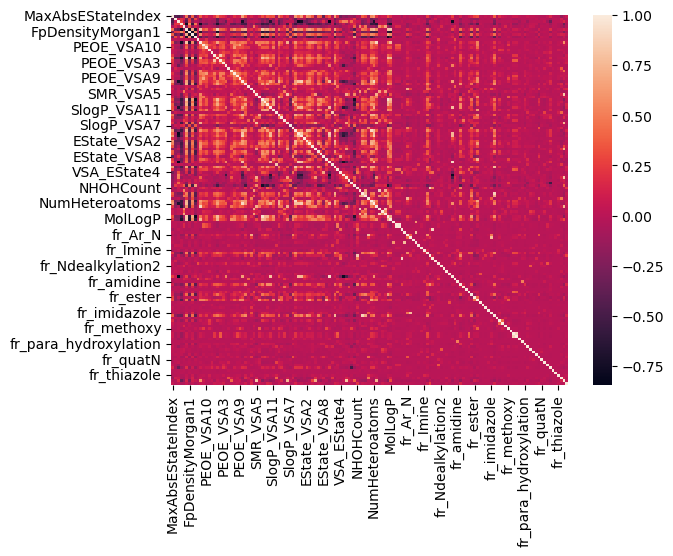

In [13]:
correlation_matrix = feature_df.iloc[:, 0:142].dropna(axis=1).corr()
sns.heatmap(correlation_matrix)


In [14]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper_tri.stack().sort_values(ascending=False)

In [15]:
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.85)]
print("Columns to drop:", to_drop)

Columns to drop: ['PEOE_VSA14', 'EState_VSA10', 'NumHAcceptors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'RingCount', 'fr_Al_OH_noTert', 'fr_NH2', 'fr_alkyl_halide', 'fr_imide', 'fr_nitro_arom_nonortho']


In [16]:
selected_features = feature_df.drop(columns=to_drop)

In [19]:
data = pd.concat([train_data, selected_features.reset_index(drop=True)], axis=1)

In [ ]:
def run_optuna():
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    for target in config.TARGET_LIST:
        sub_df = data[data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')
        X = sub_df.filter(items=['id']).join(data.iloc[:, 8:])
        X = X.clip(upper=1e10)
        y = sub_df.loc[:, target]

        with open(f'data/{target}_split.json', 'r') as f:
            target_split = json.load(f)

        study_name = f'{target}_XGB_{datetime.datetime.now()}'
        study = optuna.create_study(direction='minimize', 
                                    sampler=optuna.samplers.TPESampler(seed=SEED), 
                                    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                                    study_name=study_name)
        study.optimize(lambda trial: objective(trial=trial, datasail_split=target_split, X=X, y=y), n_trials=100, show_progress_bar=True)
        print(f'For target: {target} MAE:{study.best_value}')

        model_params_log = Path('models') / study_name
        with open(model_params_log, 'w') as f:
            json.dump(study.best_params, f)

In [17]:
def train_model(target, data, parameters_path):
    sub_df = data[data[target].notnull()].drop_duplicates(subset='SMILES', inplace=False, keep='first')
    X = sub_df.filter(items=['id']).join(data.iloc[:, 8:])
    X = X.clip(upper=1e10)
    y = sub_df.loc[:, target]

    params_json = Path(parameters_path) / f'{target}_best_params.json'
    save_path = Path(parameters_path) / f'{target}_model.json'

    with open(params_json, 'r') as f:
        params = json.load(f)

    num_boost_round = params.pop('n_estimators')
    dtrain = xgb.DMatrix(X.drop(columns=['id']), label=y)
    xgb_model = xgb.train(
        params,
        dtrain, 
        num_boost_round=num_boost_round
        )
    
    xgb_model.save_model(str(save_path))
    
    return xgb_model


In [18]:
def predict_model(model, data):
    feature_df = pd.json_normalize(data['SMILES'].apply(config.vectorize_smiles))
    selected_features = feature_df.drop(columns=to_drop)
    dmatrix = xgb.DMatrix(selected_features)
    y_pred = model.predict(dmatrix)
    return y_pred


In [50]:
for target in config.TARGET_LIST:
    model = train_model(target, data, 'models/XGB_2025-07-21_14_10_15')
    prediction = predict_model(model, test_data)
    print(prediction)
    

[0.37804982 0.37691984 0.3508626 ]
[167.69753 150.80347 138.95563]
[0.1905792  0.24360459 0.26411954]
[1.1404396 1.1106408 1.088024 ]
[21.4049   21.243351 21.005678]


In [33]:
results = {'id': test_data['id'].to_list()}
for target in config.TARGET_LIST:
    save_path = Path('models/XGB_2025-07-21_14_10_15') / f'{target}_model.json'
    model = xgb.Booster()
    model.load_model(save_path)
    prediction = predict_model(model, test_data)
    results[target] = prediction


In [37]:
pd.DataFrame(results).set_index('id').to_csv('submission.csv')